In [1]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns

In [2]:
traffic_pd = pd.read_csv('../../Data/afterPreprocess.csv')
traffic_pd

,Reference Number,Grid Ref: Easting,Grid Ref: Northing,Number of Vehicles,Accident Date,Time (24hr),1st Road Class,Road Surface,Lighting Conditions,Weather Conditions,Type of Vehicle,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty
0,140000717,429427,433921,2,2014-01-01,14:15:00,A(M),Dry,Daylight: Street lights present,Fine without high winds,Car,Passenger,Slight,Male,28
1,140012302,430481,433453,1,2014-01-01,00:05:00,Unclassified,Dry,Darkness: Street lights present and lit,Fine without high winds,Taxi/Private hire car,Passenger,Slight,Male,29
2,140000292,428515,437286,3,2014-01-01,02:20:00,Unclassified,Dry,Daylight: Street lights present,Fine without high winds,Car,Driver,Slight,Female,21
3,140000304,429117,439812,1,2014-01-01,01:30:00,Unclassified,Wet/Damp,Darkness: Street lights present and lit,Fine without high winds,Car,Pedestrian,Serious,Female,34
4,140000717,429427,433921,2,2014-01-01,14:15:00,A(M),Dry,Daylight: Street lights present,Fine without high winds,Car,Driver,Slight,Male,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13834,6CU0181,442094,434619,1,2019-12-30,04:22:00,Motorway,Wet/Damp,Darkness: Street lights present and lit,Fine with high winds,Car,Driver,Slight,Male,27
13835,6CU0363,423019,437653,1,2019-12-30,10:00:00,A,Frost/Ice,Daylight: Street lights present,Fine without high winds,Motorcycle over 500cc,Driver,Serious,Male,36
13836,6CV0723,436853,442515,2,2019-12-31,13:40:00,A,Dry,Daylight: Street lights present,Fine without high winds,Pedal cycle,Driver,Serious,Male,59
13837,6CV1518,421466,433999,3,2019-12-31,16:40:00,A,Dry,Darkness: Street lights present and lit,Fine without high winds,Car,Driver,Slight,Male,41


# Độ tuổi của các đối tượng bị tai nạn

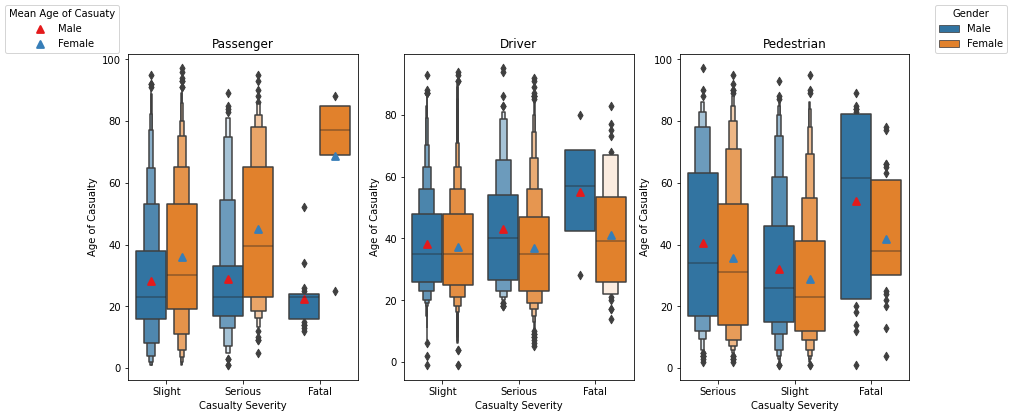

In [3]:
casualty_class = traffic_pd['Casualty Class'].unique()

fig, axes = plt.subplots(1, 3, figsize=(14, 6))
for i in range(len(casualty_class)):
    data_df = traffic_pd[traffic_pd['Casualty Class'] == casualty_class[i]]
    sns.boxenplot(data=data_df, x='Casualty Severity', y='Age of Casualty', hue='Sex of Casualty', ax=axes[i])
    sns.pointplot(data=data_df, x='Casualty Severity', y='Age of Casualty', hue='Sex of Casualty',
                  linestyles='None', errwidth=0, dodge=0.4, markers=['^', '^'], palette='Set1', ax=axes[i])
    
    axes[i].get_legend().remove()
    axes[i].set_title(casualty_class[i])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], title='Gender')
fig.legend(handles[2:], labels[2:], title='Mean Age of Casuaty', loc='upper left')

plt.show()

Có thể thấy trong cả 3 đối tượng bị tai nạn giao thông, độ tuổi trung bình của những nạn nhân nam thường thấp hơn so với nữ.
- Với mức độ nhẹ và nghiêm trọng:
    - Nam trong khoảng 20 - 40 tuổi thường bị tai nạn nhiều nhất
    - Với nữ thì trong khoảng 20 - 60 tuổi.
- Đặc biệt với các trường hợp người điều khiển phương tiện tử vong: nạn nhân nam vừa trẻ hơn và nhiều hơn so với nạn nhân nữ, có trường hợp trẻ nhất ~10 tuổi.

    $\rightarrow$ Điều này có thể do người điều khiển bị phương tiện khác gây tai nạn hay điều khiển phương tiện khi chưa đủ tuổi, không an toàn và gây tai nạn?
    
Ngược lại việc có nhiều người cao tuổi bị tai nạn là nữ hơn so với nam cũng có thể đặt nghi vấn như trên

# Vị trí của các vụ tai nạn

Trong tập dữ liệu có 2 trường `Grid Ref: Easting` và `Grid Ref: Northing` thể hiện tọa độ của nơi xảy ra vụ tai nạn. Tuy nhiên tọa độ này đang được biểu diễn dưới dạng Hệ thống tham chiếu lưới quốc gia của nước Anh, trong khi các công cụ trực quan chỉ làm việc tốt với hệ tọa độ kinh độ và vĩ độ. Ở phần này thực hiện các công việc:
- Chuyển đổi tọa độ về dạng kinh độ và vĩ độ.
- Sử dụng công cụ Tableau để trực quan các tọa độ được chuyển đổi ở trên.

## Chuyển đổi tọa độ

[Tham khảo: chuyển đổi giữa tọa độ Easting - Northing và kinh độ - vĩ độ](https://scipython.com/book/chapter-2-the-core-python-language-i/additional-problems/converting-between-an-os-grid-reference-and-longitudelatitude/)

In [7]:
import math

In [8]:
def scale_lat_coord(phi, F0=0.9996012717, a=6377563.396, b=6356256.909, phi0=math.radians(49)):
    n = (a - b) / (a + b)
    n2 = n ** 2; n3 = n ** 3
    dphi, sphi = phi - phi0, phi + phi0
    
    return (b * F0) * ((1 + n + (5/4)*(n2+n3)) * dphi
                      - ((3*n + 3*n2 + (21/8)*(n3)) * math.sin(dphi) * math.cos(sphi))
                      + (((15/8)*(n2) + (15/8)*(n3)) * math.sin(2*dphi) * math.cos(2*sphi))
                      - ((35/24)*(n3) * math.sin(3*dphi) * math.cos(3*sphi))
                      )

In [9]:
def grid_to_ll(grid, a=6377563.396, b=6356256.909, N0=-100000, F0=0.9996012717, lambda0=math.radians(-2), E0=400000):
    M = phip = 0
    e2 = (a**2 - b**2) / (a**2)
    
    while abs(grid[1] - N0 - M) >= 1e-5:
        phip += (grid[1] - N0 - M) / (a * F0)
        M = scale_lat_coord(phip)
        
    sin_phip2 = math.sin(phip)**2
    nu = (a * F0) / math.sqrt(1 - e2 * sin_phip2)
    rho = (a * F0) / ((1 - e2) / (1 - e2*sin_phip2)**(3/2))
    eta2 = (nu / rho) - 1
    
    tan_phip = math.tan(phip); tan_phip2 = tan_phip**2
    sec_phip = 1 / math.cos(phip)
    
    c1 = tan_phip / (2*rho*nu)
    c2 = tan_phip / (24*rho*nu**3) * (5 + (3 - 9*eta2)*tan_phip2 + eta2)
    c3 = tan_phip / (720*rho*nu**5) * (61 + (90 + 45*tan_phip2)*tan_phip2)
    
    d1 = sec_phip / nu
    d2 = sec_phip / (6*nu**3) * ((nu / rho) + 2*tan_phip2)
    d3 = sec_phip / (120*nu**5) * (5 + (28 + 24*tan_phip2)*tan_phip2)
    d4 = sec_phip / (5040*nu**7) * (61 + (662 + (1320 + 720*tan_phip2)*tan_phip2)*tan_phip2)
    
    e_e0 = grid[0] - E0; e_e0_2 = e_e0**2
    phi = phip - (c1 + (c2 - c3*e_e0_2)*e_e0_2)*e_e0_2
    lamb = lambda0 + (d1 + (-d2 + (d3 - d4*e_e0_2)*e_e0_2)*e_e0_2)*e_e0
    
    return (math.degrees(phi), math.degrees(lamb))

In [10]:
years = list(range(2014, 2020))
for year in years:
    traffic_year = traffic_pd[traffic_pd['Accident Date'].str.contains(str(year), regex=False)]
    coords = traffic_year[['Grid Ref: Easting', 'Grid Ref: Northing']].apply(grid_to_ll, axis=1)
    
    file = open(f'coord_{year}.csv', 'w', encoding='utf-8')
    file.write('Latitude,Longitude\n')

    for c in coords:
        file.write(f'{c[0]},{c[1]}\n')

    file.close()

## Trực quan các vị trí xảy ra tai nạn

Dưới đây thể hiện kết quả trực quan vị trí các vụ tai nạn với tọa độ (kinh độ, vĩ độ) được tính ở trên. Sử dụng công cụ `Tableau` để trực quan.

### Năm 2014
![2014.png](../../Data/2014.png)

### Năm 2015

![2015.png](../../Data/2015.png)

### Năm 2016

![2016.png](../../Data/2016.png)

### Năm 2017

![2017.png](../../Data/2017.png)

### Năm 2018

![2018.png](../../Data/2018.png)

### Năm 2019

![2019.png](../../Data/2019.png)

# Những khu vực tập trung nhiều vụ tai nạn nhất

Liệt kê những khu vực quận/huyện tập trung nhiều vụ tai nạn nhất trong năm 2017. Bao gồm các bước:
- Gom nhóm các vị trí xảy ra tai nạn thành các cụm.
- Tìm vị trí các tâm cụm trên bản đồ và lấy ra tên đường/quận/huyện.
- Đếm số lượng những vụ tai nạn xảy ra trong cụm đó.

In [2]:
traffic_17 = pd.read_csv('../../Data/data_2017.csv')

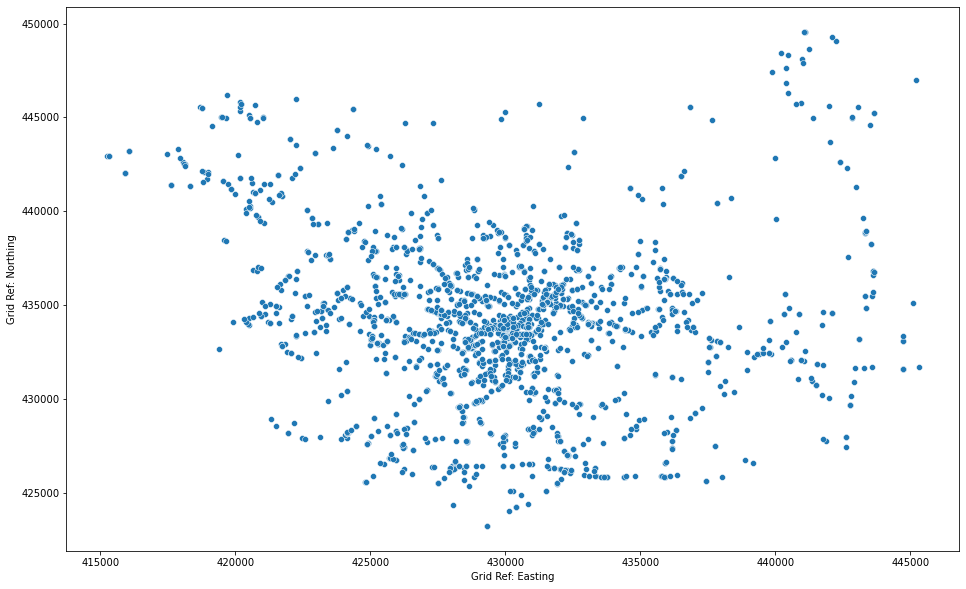

In [3]:
fig, ax = plt.subplots(figsize=(16, 10))
# sns.scatterplot(data=traffic_17, x='Latitude', y='Longitude', ax=ax)
sns.scatterplot(data=traffic_17, x='Grid Ref: Easting', y='Grid Ref: Northing', ax=ax)
fig.show()

In [4]:
from sklearn.cluster import KMeans

cluster_model = KMeans(n_clusters=12, max_iter=500, random_state=0)

In [5]:
traffic_17['Labels'] = cluster_model.fit_predict(traffic_17[['Grid Ref: Easting', 'Grid Ref: Northing']])
(cluster_model.cluster_centers_).round(0)

array([[429850., 431705.],
       [425435., 438593.],
       [435766., 434439.],
       [441290., 445718.],
       [426855., 427732.],
       [442094., 433092.],
       [431274., 434717.],
       [433331., 427135.],
       [428058., 434723.],
       [420146., 442486.],
       [431780., 439112.],
       [423535., 434238.]])

[**Kết quả tìm kiếm các vị trí tâm cụm**](https://gridreferencefinder.com?gr=SE2985031705|429850_s__c__s_431705|1,SE2543538593|425435_s__c__s_438593|1,SE3576634439|435766_s__c__s_434439|1,SE4129045718|441290_s__c__s_445718|1,SE2685527732|426855_s__c__s_427732|1,SE4209433092|442094_s__c__s_433092|1,SE3127434717|431274_s__c__s_434717|1,SE3333127135|433331_s__c__s_427135|1,SE2805834723|428058_s__c__s_434723|1,SE2014642486|420146_s__c__s_442486|1,SE3178039112|431780_s__c__s_439112|1,SE2353534238|423535_s__c__s_434238|1&v=r&labels=1)

In [6]:
import re

In [7]:
address_df = pd.read_csv('../../Data/address.csv', usecols=['Address (near)'])
address_df['Counts'] = (traffic_17.groupby('Labels').size())

pd.options.display.max_colwidth = None
address_df.sort_values('Counts', ascending=False, inplace=True)

address_df['Address (near)'] = address_df['Address (near)'].apply(lambda x: x[:re.search('Leeds', x).start() - 2])
address_df.index.set_names('Labels', inplace=True)
address_df

,Address (near),Counts
Labels,,
6,"Rosebud Walk, Burmantofts",431
8,IconInc - The Glassworks - Student Accommodatio,314
0,"Disraeli Terrace, Beeston Hill",302
11,"Rycroft Avenue, Stanningley, Pudsey",177
4,"Tennyson Street, Morley",175
7,"Westfield Road, Howlett Cross, Carlton",168
2,"Cold Well Road, Whitkirk, Colton",154
10,"Kedleston Road, Wigton Moor, Roundhay",121
1,"Tinshill, Horsforth",113


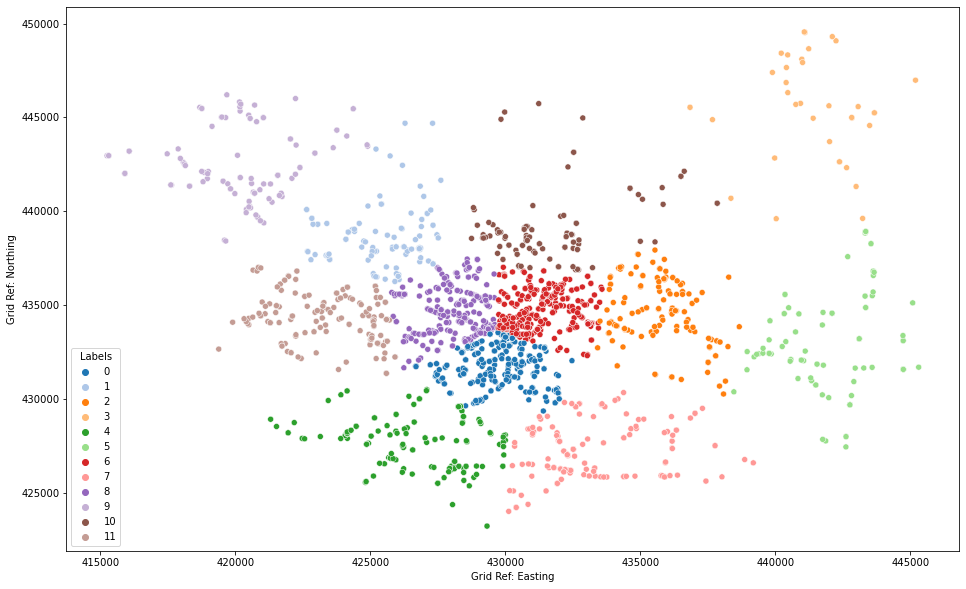

In [8]:
fig, ax = plt.subplots(figsize=(16, 10))
# sns.scatterplot(data=traffic_17, x='Latitude', y='Longitude', ax=ax, hue='Labels', palette='Paired')
sns.scatterplot(data=traffic_17, x='Grid Ref: Easting', y='Grid Ref: Northing', hue='Labels', palette='tab20', ax=ax)
fig.show()

In [9]:
plt.close(fig)